In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import json
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data import ExprData
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [40]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

plt.rc('legend', fontsize=SMALL_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import random
np.random.seed(47907)
random.seed(15213)

In [3]:
all_groups = ['10', '11', '12']
candidate_group = '10'

from_sku = 'cpu2'
to_sku = 'cpu8'

In [4]:
'''
Generate scatter plot by similarity
Attributes:
    simi_mtxs : list of simi_mtxs or simi_col_mtxs using different number of features
    simi_data : should be same for all simi_mtxs
    feature_groups: labels of the feature group: top3, top7, plan, resource, all
    root_idx: the i-th experiment as the base run, will plot pairwise distance between the base run and other runs
    method_type: Type of method used to calculate similarity
    colwise: True if the calculation is columnwised, False if not
'''
def plot_scores_diff_feature_num(simi_mtxs, simi_data, feature_groups, root_idx, method_type, colwise=False, note=''):
    fig, ax = plt.subplots(figsize=(3*len(feature_groups), 2.8))
    zipped = []
    for simi_mtx, feature_group in zip(simi_mtxs, feature_groups):       
        curr_zipped = list(zip(simi_data.wl_groups, simi_data.wl_names, [feature_group]*simi_data.get_num_exprs(), simi_mtx[root_idx]))
        del curr_zipped[root_idx]
        zipped += curr_zipped
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','feature_group', 'distance'])
    X_p = X_p.astype({'distance': float})
    X_p.drop([root_idx],inplace=True)

    order=['tpcc', 'tpch', 'twitter']
    if X_p['workload'].nunique() == 4:
        order.append('ycsb')
    
    sns.barplot(y="distance", x="feature_group", hue_order=order,
                hue="workload", data=X_p, ax=ax, 
                palette=sns.color_palette()[:X_p['workload'].nunique()])
    plt.xlabel('')
    plt.ylabel('Normalized Distance')
    
    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 
    cpu_num_val = simi_data.cpu_nums[root_idx]
    if colwise:
        colwise_label = 'Independent'
    else:
        colwise_label = 'Dependent'
    title = 'Base Workload: {}, Method: {} {}.{}'.format(
        wl_name, cpu_num_val, colwise_label, method_type, note)
    fname = '{}{}_cpu{}_{}_{}{}.pdf'.format(wl_name, expr_idx, cpu_num_val, colwise_label, method_type, note)
    plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=4, mode="expand")
    print(title)
    plt.savefig(f'figs/ycsb_{fname}', bbox_inches = 'tight')
    plt.show()

In [42]:
def plot_scores_single(simi_mtx, simi_data, root_idx, data_type, method_type, note=''):
    # fig, ax = plt.subplots(figsize=(3.2,1.3))
    fig, ax = plt.subplots(figsize=(3,4))

    zipped = list(zip(simi_data.wl_groups, simi_data.wl_names, simi_data.cpu_nums, simi_mtx[root_idx]))
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','cpu_num', 'distance'])
    X_p = X_p.astype({'distance': float})
    X_p.drop([root_idx],inplace=True)
    
    order=['tpcc', 'tpch', 'twitter']
    if X_p['workload'].nunique() == 4:
        order.append('ycsb')

    sns.barplot(y="distance", x="workload", order=order,
                data=X_p, ax=ax, errorbar="sd",
                palette=sns.color_palette()[:X_p['workload'].nunique()])
    ax.set_xticklabels(['TPC-C', 'TPC-H', 'Twitter', 'YCSB'])

    ax.set_xlabel('')
    ax.set_ylabel('Distance')

    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 
    candid = f'Ycsb{candidate_group}'

    plt.savefig(f'figs/Test_Single_{candid}_2.pdf', bbox_inches = 'tight')
    plt.show()

In [6]:
def get_simis(simi_data, simi_mtx, candid_idx):
    print(simi_data.cpu_nums[candid_idx])
    arr = []
    true_idx = []
    for idx, val in enumerate(simi_mtx[candid_idx][:-12]):
        if simi_data.cpu_nums[idx] == simi_data.cpu_nums[candid_idx]:
            arr.append(val)
            true_idx.append(idx)
   
    nearest = np.argsort(arr)
    nearest_wls = np.array([simi_data.wl_groups[true_idx[i]] for i in nearest])
    _, idx = np.unique(nearest_wls, return_index=True)
    tops = nearest_wls[np.sort(idx)]
    return tops

In [7]:
data = ExprData()
data.load_pickle()
data.fix_tpch()

data = data.remove_by_group([g for g in all_groups if g != candidate_group])
data = data.remove_by_wlname(['xml'])

In [8]:
data_by_sku = data.split_by_sku()
known_data = data_by_sku[from_sku]
pred_data = data_by_sku[to_sku]

In [9]:
# similarity for all
scaler = ScaleData()
plan_mtxs, plan_col_ranges = scaler.scale(known_data.plan_mtxs)
perf_mtxs, perf_col_ranges = scaler.scale(known_data.perf_mtxs)

simi_calc = Similarity(known_data, plan_mtxs, plan_col_ranges, perf_mtxs, perf_col_ranges)
simi_calc.calc_bined_mtx() # all features

In [10]:
fs = FeatureSelection(simi_calc)

In [11]:
# use for later distinguish btw plan and system metrics
perf_features = known_data.perf_feature_cols
plan_features = known_data.plan_feature_cols
all_features = known_data.feature_cols

feature_group_all = ['plan_3', 'plan_7', 'plan', 'resource_3', 'resource_5', 'resource', 'all_3', 'all_7', 'all']
feature_group_plan = ['plan_3', 'plan_7', 'plan']
feature_group_perf = ['resource_3', 'resource_5', 'resource']

top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type=None)
top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type=None)
plan_top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type='plan')
perf_top_3 = fs.select_features(3, 'fANOVA', est_name=None, direction=None, feature_type='perf')
plan_top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type='plan')
perf_top_7 = fs.select_features(5, 'fANOVA', est_name=None, direction=None, feature_type='perf')

features_all = [plan_top_3, plan_top_7, plan_features, perf_top_3, perf_top_7, perf_features, top_3, top_7, all_features]
features_plan = [plan_top_3, plan_top_7, plan_features]
features_perf = [perf_top_3, perf_top_7, perf_features]

(30, 30, 29)
(30, 30, 29)
(30, 30, 22)
(30, 30, 7)
(30, 30, 22)
(30, 30, 7)


In [12]:
top_3

['AvgRowSize', 'MaxCompileMemory', 'CachedPlanSize']

In [13]:
top_7

['AvgRowSize',
 'MaxCompileMemory',
 'CachedPlanSize',
 'EstimateRows',
 'StatementEstRows',
 'MEM_UTILIZATION',
 'SerialRequiredMemory']

In [14]:
plan_top_3

['AvgRowSize', 'MaxCompileMemory', 'StatementEstRows']

In [15]:
plan_top_7

['AvgRowSize',
 'MaxCompileMemory',
 'StatementEstRows',
 'CachedPlanSize',
 'SerialRequiredMemory',
 'EstimateRows',
 'TableCardinality']

In [16]:
perf_top_3

['MEM_UTILIZATION', 'LOCK_REQ_ABS', 'READ_WRITE_RATIO']

In [17]:
perf_top_7

['MEM_UTILIZATION',
 'LOCK_REQ_ABS',
 'READ_WRITE_RATIO',
 'CPU_UTILIZATION',
 'CPU_EFFECTIVE']

In [18]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='l21')#, normalize=False)
    simi_mtxs.append(simi_calc.simi_mtx)

In [19]:
candid_idx = len(known_data.wl_names) - 3

Base Workload: ycsb, Method: cpu2 Independent.cumHistL21


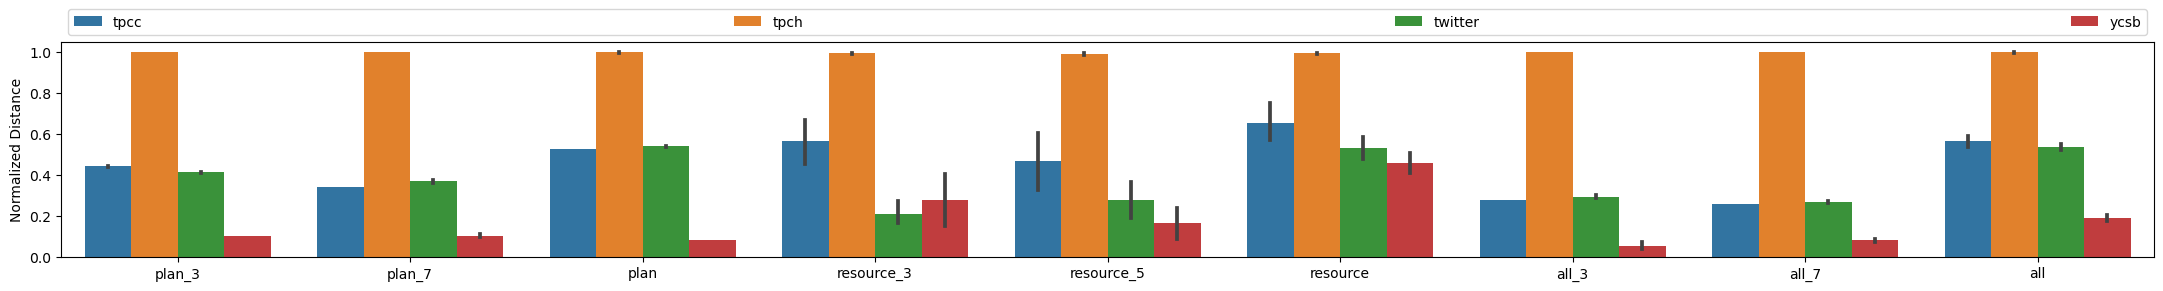

In [20]:
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, candid_idx, 'cumHistL21', colwise=True, note='')

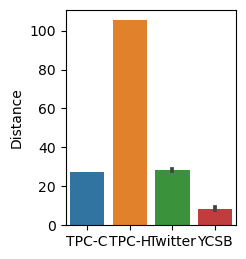

In [33]:
simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=top_7, norm_type='l21', normalize=False)

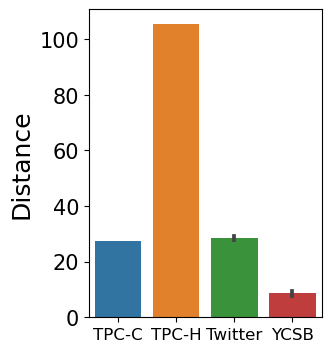

In [43]:
plot_scores_single(simi_calc.simi_mtx, simi_calc.data, candid_idx, 'Top7', 'Cumulative Histogram L21 Norm', note='')

In [22]:
tops = get_simis(simi_calc.data, simi_calc.simi_mtx, candid_idx)

cpu2


In [23]:
print(tops)
simi_data = simi_calc.data
for wl in tops:
    min_idx, = np.where(np.array(simi_data.wl_groups) == wl)
    print(np.unique(np.array(simi_data.wl_names)[min_idx]), simi_data.cpu_nums[candid_idx], 
          np.unique(np.array(simi_data.terminal_num)[min_idx]), 
          np.unique(np.array(simi_data.wl_groups)[min_idx])) 

['8' '7' '1' '2' '6' '5']
['tpcc'] cpu2 [4] ['8']
['tpcc'] cpu2 [8] ['7']
['tpcc'] cpu2 [32] ['1']
['tpch'] cpu2 [32] ['2']
['tpch'] cpu2 [4] ['6']
['tpch'] cpu2 [8] ['5']
